In [5]:
import os
import locale
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [6]:
# Paramètres de connexion
host = "localhost"  # ou l'adresse IP du serveur PostgreSQL
database = "atm_etl"
user = "postgres"
password = "emna4321"
port = "5432"  # Port par défaut de PostgreSQL

# 1. Connexion avec psycopg2 (pour les opérations de base)
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password,
    port=port
)

# 2. Connexion SQLAlchemy (pour pandas)
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# 3. Chargement des données
query = "SELECT * FROM fact_chargs_dechargs;"  # Remplacez par votre requête
df = pd.read_sql(query, engine)



 

In [7]:
# 3. Prétraitement des données
# ----------------------------------------------------

# Conversion des dates
df['date_chargement'] = pd.to_datetime(df['date_chargement'])
# Vérification

print("Aperçu des données :")
print(df.head())
print("\nStatistiques des montants :")
print(df['montant_chargés'].describe())

Aperçu des données :
   montant_existant  montant_différentiel  montant_chargés  montant_déchargés  \
0            4170.0                   0.0          60000.0            55830.0   
1           20290.0                   0.0          60000.0            39710.0   
2            5530.0                   0.0          40000.0            34470.0   
3           17390.0                   0.0          60000.0            42610.0   
4           37060.0                   0.0          60000.0            22940.0   

               agence_nom date_chargement date_dechargement  code_cass  
0             SIEGE LAC 2      2023-01-05        2023-01-11     8570.0  
1           AGENCE MIDOUN      2023-01-05        2023-01-06     8590.0  
2        AGENCE EL MENZAH      2023-01-05        2023-01-06     8610.0  
3  AGENCE MENZEL BOUZELFA      2023-01-05        2023-01-06     8630.0  
4          AGENCE METLINE      2023-01-05        2023-01-06     9370.0  

Statistiques des montants :
count     32882.000000
me

In [8]:
def create_features_temporelles(df):
    df['date_chargement'] = pd.to_datetime(df['date_chargement'])
    # Features de base 
    df['semaine_annee'] = df['date_chargement'].dt.isocalendar().week
    df['trimestre'] = df['date_chargement'].dt.quarter
    df['est_weekend'] = df['date_chargement'].dt.dayofweek.isin([5, 6]).astype(int)
    df['est_debut_mois'] = (df['date_chargement'].dt.day <= 7).astype(int)
    df['est_fin_mois'] = (df['date_chargement'].dt.day > 24).astype(int)
    
    return df
df = create_features_temporelles(df)


In [9]:
# 2. 	Choisir les colonnes à utiliser et verification
feature_cols = [
    'montant_chargés',          # Colonne cible + feature
    'semaine_annee',            # Feature temporelle existante
    'trimestre',                # Feature temporelle existante
    'est_weekend',              # Feature binaire existante
    'est_debut_mois',           # Feature binaire existante
    'est_fin_mois',             # Feature binaire existante
]

# Vérification critique des colonnes disponibles
missing_cols = [col for col in feature_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"""
    ERREUR: Colonnes manquantes dans le DataFrame.
    Colonnes requises: {feature_cols}
    Colonnes manquantes: {missing_cols}
    Colonnes disponibles: {list(df.columns)}
    """)

print("✅ Configuration des features validée")
print(f"Nombre total de features: {len(feature_cols)}")
print(f"Détail des features: {feature_cols}")

✅ Configuration des features validée
Nombre total de features: 6
Détail des features: ['montant_chargés', 'semaine_annee', 'trimestre', 'est_weekend', 'est_debut_mois', 'est_fin_mois']


In [11]:
def split_temporal_train_test(df, split_ratio=0.8):
    df = df.sort_values('date_chargement').reset_index(drop=True)
    split_index = int(len(df) * split_ratio)
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]
    return df_train, df_test


In [12]:
def prepare_sequences(data, agence, sequence_length=14, feature_cols=None):
    agence_data = data[data['agence_nom'] == agence].sort_values('date_chargement')
    if agence_data.empty:
        raise ValueError(f"Aucune donnée trouvée pour l'agence '{agence}'")
 
    if feature_cols is None:
        feature_cols = [
            'montant_chargés', 
            'semaine_annee',
            'trimestre',
            'est_weekend',
            'est_debut_mois',
            'est_fin_mois'
        ]
    missing_cols = [col for col in feature_cols if col not in agence_data.columns]
    if missing_cols:
        raise ValueError(f"Colonnes manquantes dans les données : {missing_cols}")
    agence_data = agence_data.dropna(subset=feature_cols)
    features = agence_data[feature_cols].values
    if len(features) <= sequence_length:
        raise ValueError(f"Pas assez de données ({len(features)}) pour créer des séquences de longueur {sequence_length}")
    # Création des séquences
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(features[i + sequence_length][0])  # On prédit toujours 'montant_chargés'
    if not X:
        raise ValueError("Aucune séquence n'a été créée. Vérifiez vos données et vos paramètres.")
    return np.array(X), np.array(y)


In [19]:
def normalize_data(X, y, scaler=None, y_scaler=None, fit_scaler=True):
    if scaler is None:
        scaler = MinMaxScaler()
    if y_scaler is None:
        y_scaler = MinMaxScaler()
    
    # Normalisation des features
    original_shape = X.shape
    X_reshaped = X.reshape(-1, original_shape[2])
    
    try:
        if fit_scaler:
            X_scaled = scaler.fit_transform(X_reshaped)
        else:
            X_scaled = scaler.transform(X_reshaped)
    except Exception as e:
        raise ValueError(f"Erreur normalisation X: {str(e)}")
    
    X_scaled = X_scaled.reshape(original_shape)
    
    # Normalisation de la target
    y_reshaped = y.reshape(-1, 1)
    
    try:
        if fit_scaler:
            y_scaled = y_scaler.fit_transform(y_reshaped)
        else:
            y_scaled = y_scaler.transform(y_reshaped)
    except Exception as e:
        raise ValueError(f"Erreur normalisation y: {str(e)}")
    
    return X_scaled, y_scaled.flatten(), scaler, y_scaler

In [21]:
def reshape_for_lstm(X, y=None):
    """
    Reshape les données X pour le LSTM.
    Si X est 2D, reshape en (samples, timesteps, features).
    Si X est déjà 3D, le retourne tel quel.
    """
    if X.ndim == 2:
        X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    elif X.ndim == 3:
        X_reshaped = X
    else:
        raise ValueError(f"Shape non supporté: {X.shape}")

    return (X_reshaped, y) if y is not None else X_reshaped


In [23]:
# 1. Split temporel 80/20
df_train, df_test = split_temporal_train_test(df, split_ratio=0.8)

# 2. Choisir une agence existante
agences_disponibles = df['agence_nom'].unique()
agence_selectionnee = agences_disponibles[0]  # Exemple : la première agence

# 3. Définir les features
feature_cols = [
    'montant_chargés',
    'semaine_annee',
    'trimestre',
    'est_weekend',
    'est_debut_mois',
    'est_fin_mois'
]
feature_cols = [col for col in feature_cols if col in df.columns]

print("Agence sélectionnée :", agence_selectionnee)
print("Features utilisées :", feature_cols)

try:
    # 4. Préparer les séquences pour train
    X_train, y_train = prepare_sequences(df_train, agence_selectionnee, sequence_length=14, feature_cols=feature_cols)

    # 5. Préparer les séquences pour test
    X_test, y_test = prepare_sequences(df_test, agence_selectionnee, sequence_length=14, feature_cols=feature_cols)

    # 6. Normalisation
    X_train_scaled, y_train_scaled, scaler, y_scaler = normalize_data(X_train, y_train, fit_scaler=True)
    X_test_scaled, y_test_scaled, _, _ = normalize_data(X_test, y_test, scaler=scaler, y_scaler=y_scaler, fit_scaler=False)

    # 7. Reshape pour LSTM
    X_train_final, y_train_final = reshape_for_lstm(X_train_scaled, y_train_scaled)
    X_test_final, y_test_final = reshape_for_lstm(X_test_scaled, y_test_scaled)

    print("\n Données prêtes pour le LSTM !")
    print("Train X shape :", X_train_final.shape)
    print("Train y shape :", y_train_final.shape)
    print("Test X shape  :", X_test_final.shape)
    print("Test y shape  :", y_test_final.shape)

except Exception as e:
    print("\n❌ Erreur lors de la préparation :", str(e))
    print("Vérifiez :")
    print("- Données suffisantes pour l'agence")
    print("- Colonnes bien présentes")
    print("- Formats et types corrects")


Agence sélectionnée : SIEGE LAC 2
Features utilisées : ['montant_chargés', 'semaine_annee', 'trimestre', 'est_weekend', 'est_debut_mois', 'est_fin_mois']

 Données prêtes pour le LSTM !
Train X shape : (74, 14, 6)
Train y shape : (74,)
Test X shape  : (4, 14, 6)
Test y shape  : (4,)


In [25]:
def create_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(
        lstm_units,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=L1L2(l2=1e-4) ))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(
        lstm_units // 2,
        activation='tanh' ))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    # Couche de sortie (régression)
    model.add(Dense(1)) 
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[
            MeanAbsoluteError(name='mae'),
            RootMeanSquaredError(name='rmse')]  )
    return model

In [27]:
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    return model

In [29]:
def get_callbacks(model_name='lstm', patience=30, monitor='val_loss'):
    log_dir = os.path.join("logs", f"{model_name}_{datetime.now().strftime('%Y%m%d')}")
    os.makedirs(log_dir, exist_ok=True)
    return [
        EarlyStopping(
            monitor=monitor,
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f'{model_name}_best.keras',
            monitor=monitor,
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor=monitor,
            factor=0.5,
            patience=patience//2,
            min_lr=1e-5,
            verbose=1
        )
    ]
    
def train_model(model, X, y, validation_data=None, epochs=200, batch_size=32, model_name='lstm_simplified'):


    if not model_name.endswith('.keras'):
        model_name += '.keras'
    callbacks = get_callbacks(
        model_name=model_name.replace('.keras', ''),
        monitor='val_loss' if validation_data else 'loss'
    )
    start_time = datetime.now()
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        shuffle=False,
        callbacks=callbacks,
        verbose=1
    )
    
    print(f"\nTemps d'entraînement: {datetime.now() - start_time}")
    return history

# ----------------------------
# 5. Visualisation simplifiée
# ----------------------------
def plot_training_history(history):
    """
    Visualisation simplifiée :
    - Seulement loss et MAE
    - Graphique plus lisible
    """
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Evolution de la Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train')
    if 'val_mae' in history.history:
        plt.plot(history.history['val_mae'], label='Validation')
    plt.title('Evolution du MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [31]:
def predict_and_evaluate(agence_name="AGENCE MONTFLEURY", sequence_length=14):
    try:
        # 1. Chargement des données
        df = pd.read_sql("SELECT * FROM fact_chargs_dechargs", engine)
        df = create_features_temporelles(df)

        # 2. Filtrage des données de l'agence
        agence_data = df[df['agence_nom'] == agence_name].sort_values('date_chargement')
        if agence_data.empty:
            raise ValueError(f"Aucune donnée pour {agence_name}")

        # 3. Définition des features
        feature_cols = [
            'montant_chargés',
            'semaine_annee',
            'trimestre',
            'est_weekend',
            'est_debut_mois',
            'est_fin_mois'
        ]
        missing_cols = [col for col in feature_cols if col not in agence_data.columns]
        if missing_cols:
            raise ValueError(f"Colonnes manquantes : {missing_cols}")

        # 4. Séparation temporelle
        split_index = int(len(agence_data) * 0.8)
        train_df = agence_data.iloc[:split_index]
        test_df = agence_data.iloc[split_index:]

        # 5. Séquences
        X_train, y_train = prepare_sequences(train_df, agence=agence_name,
                                             sequence_length=sequence_length,
                                             feature_cols=feature_cols)
        X_test, y_test = prepare_sequences(test_df, agence=agence_name,
                                           sequence_length=sequence_length,
                                           feature_cols=feature_cols)

        # 6. Normalisation
        X_train_scaled, y_train_scaled, scaler, y_scaler = normalize_data(X_train, y_train, fit_scaler=True)
        X_test_scaled, y_test_scaled, _, _ = normalize_data(X_test, y_test, scaler=scaler, y_scaler=y_scaler, fit_scaler=False)

        # 7. Reshape
        X_train_final, y_train_final = reshape_for_lstm(X_train_scaled, y_train_scaled)
        X_test_final, y_test_final = reshape_for_lstm(X_test_scaled, y_test_scaled)

        # 8. Modèle
        model = create_lstm_model(input_shape=(sequence_length, len(feature_cols)))
        model = compile_model(model)

        # 9. Entraînement
        history = train_model(
            model,
            X_train_final,
            y_train_final,
            validation_data=(X_test_final, y_test_final),
            epochs=200,
            batch_size=32,
            model_name=f"lstm_{agence_name.replace(' ', '_')}"
        )

        # 10. Prédictions
        y_pred_scaled = model.predict(X_test_final)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
        y_true = y_scaler.inverse_transform(y_test_final.reshape(-1, 1))

        # 11. Résultats
        result_dates = test_df['date_chargement'].iloc[sequence_length:].values
        results = pd.DataFrame({
            'Date': result_dates,
            'Valeur_Réelle': y_true.flatten(),
            'Prédiction': y_pred.flatten(),
            'Erreur (%)': ((y_true - y_pred) / y_true * 100).flatten().round(2)
        })

        # 12. Métriques
        from scipy.stats import pearsonr
        import numpy as np

        
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        final_epoch = -1
        metrics = {
            'loss': history.history['loss'][final_epoch],
            'MAE': history.history['mean_absolute_error'][final_epoch],
            'RMSE': history.history['root_mean_squared_error'][final_epoch],
            'MAPE': mape
        }

        # 13. Visualisation
        plt.figure(figsize=(14, 6))
        plt.plot(results['Date'], results['Valeur_Réelle'], label='Réel', linewidth=2)
        plt.plot(results['Date'], results['Prédiction'], label='Prédiction', linestyle='--', linewidth=2)
        plt.title(f'Performance pour {agence_name}')
        plt.xlabel("Date")
        plt.ylabel("Montant chargé")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.ylim([min(results['Valeur_Réelle'].min(), results['Prédiction'].min()) * 0.95,
                  max(results['Valeur_Réelle'].max(), results['Prédiction'].max()) * 1.05])
        plt.tight_layout()
        plt.show()

        plot_training_history(history)

        return results, metrics

    except Exception as e:
        print(f"\n❌ Erreur: {str(e)}")
        print("Vérifiez que:")
        print("- La table fact_chargs_dechargs contient bien toutes les colonnes nécessaires")
        print("- L'agence spécifiée existe dans la table")
        return None, None


Epoch 1/200
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2950 - mean_absolute_error: 0.5041 - root_mean_squared_error: 0.5416
Epoch 1: val_loss improved from inf to 0.06996, saving model to lstm_AGENCE_MONTFLEURY_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.2902 - mean_absolute_error: 0.4985 - root_mean_squared_error: 0.5373 - val_loss: 0.0700 - val_mean_absolute_error: 0.2404 - val_root_mean_squared_error: 0.2624 - learning_rate: 0.0010
Epoch 2/200
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0716 - mean_absolute_error: 0.2218 - root_mean_squared_error: 0.2648
Epoch 2: val_loss improved from 0.06996 to 0.05723, saving model to lstm_AGENCE_MONTFLEURY_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0735 - mean_absolute_error: 0.2220 - root_mean_squared_error: 0.2685 - val_loss: 0.0572 - val_mean_absolute_error: 0.1810 - val_root_mean_squared_error: 0.2369 - learning_rate: 0.0010
Epoch 3/200
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0750 - mean_absol

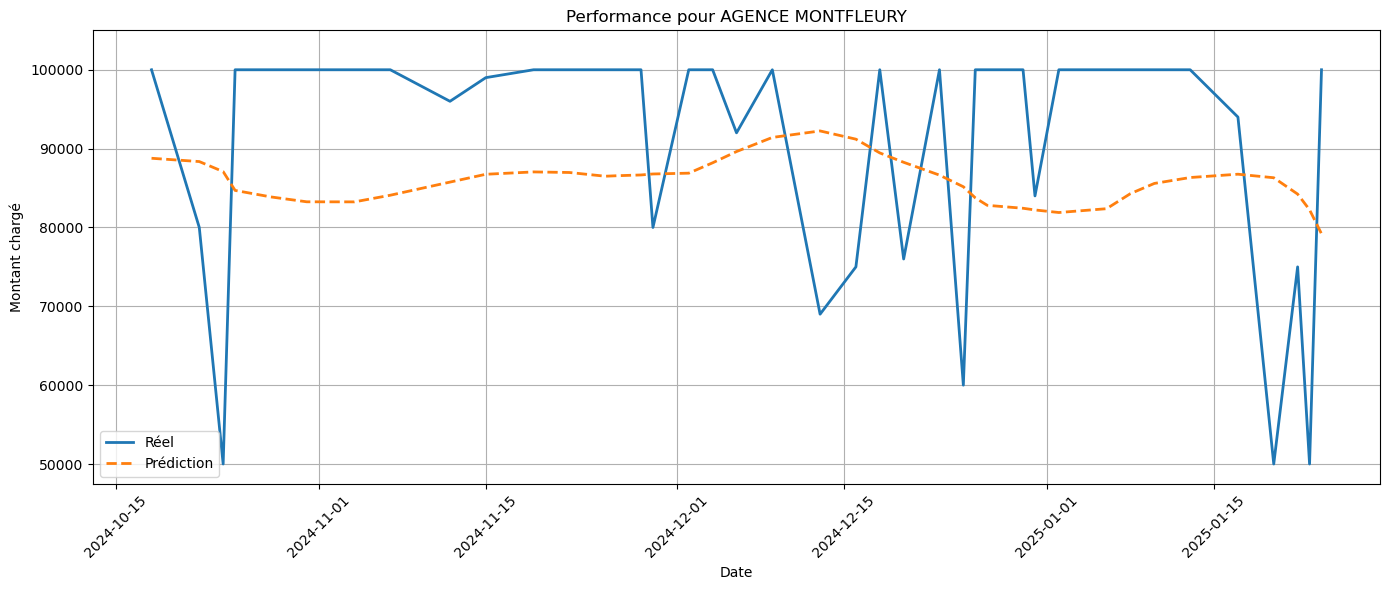

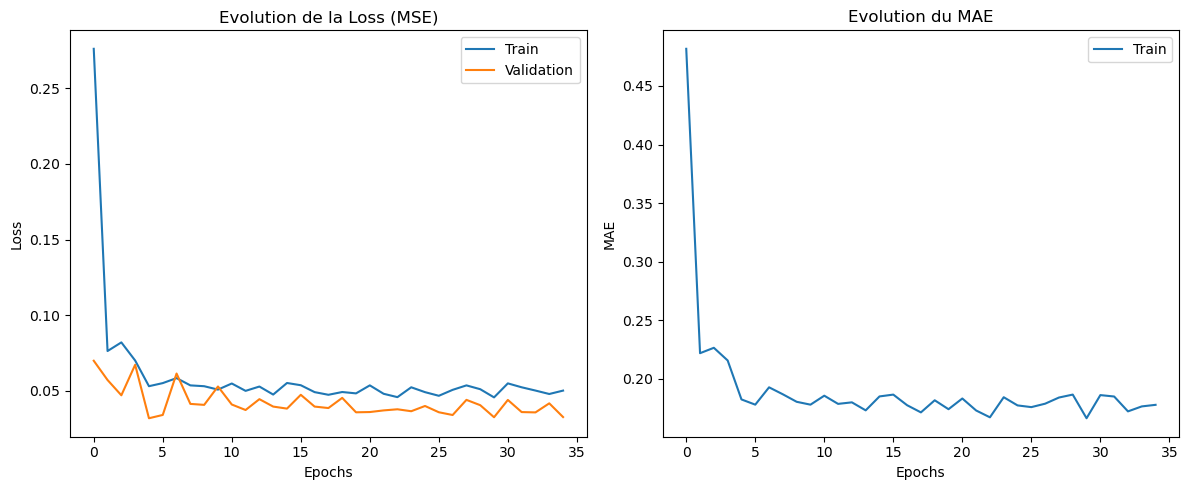


Dernières prédictions :
        Date  Valeur_Réelle    Prédiction  Erreur (%)
0 2024-10-18       100000.0  88775.210938       11.22
1 2024-10-22        80000.0  88357.289062      -10.45
2 2024-10-24        50000.0  87084.546875      -74.17
3 2024-10-25       100000.0  84697.687500       15.30
4 2024-10-28       100000.0  83871.687500       16.13

Métriques du modèle (valeurs finales) :
Loss (MSE): 0.0502
MAE       : 0.1776
RMSE      : 0.2223
MAPE      : 18.96%


In [33]:
# Exemple d'utilisation
results, metrics = predict_and_evaluate("AGENCE MONTFLEURY")

if results is not None and metrics is not None:
    print("\nDernières prédictions :")
    print(results.head())

    
    print("\nMétriques du modèle (valeurs finales) :")
    print(f"Loss (MSE): {metrics['loss']:.4f}")
    print(f"MAE       : {metrics['MAE']:.4f}")
    print(f"RMSE      : {metrics['RMSE']:.4f}")
    print(f"MAPE      : {metrics['MAPE']:.2f}%")
  